### Project Description

#### 1) Goal Statement — what we predict

Build a model that predicts daily NO2 concentration in Milan using traffic and weather. The aim is to flag high-pollution days ahead of time and to understand which levers move NO2 up or down.

#### 2) Context — why it matters

NO₂ is a key urban air pollutant linked to respiratory and cardiovascular risks. Milan sits in the Po Valley, a low, enclosed basin with frequent stagnation and winter inversions. That geography tends to trap pollution, so even moderate emissions can accumulate, making Milan one of the most polluted cities in Europe. Better forecasts help cities protect public health, evaluate traffic policies (e.g., restricted zones), and plan mitigation (alerts, transit incentives). For residents, it means clearer information about when air quality is likely to worsen.

#### 3) Target variable — what we forecast

Daily mean NO₂ (µg/m³) measured in Milan.
Timeframe: 2020–2023 (using all available, validated observations).

#### 4) Features — which factors influence it

Core predictors (already in our dataset):

- Traffic (daily transits).

- Temperature (daily mean).

- Wind (daily mean speed).

- Rain (boolean True/False).


#### 5) Stakeholders — who benefits

- City & mobility planners.

- Public health & environment teams.

- Residents & commuters. 

- NGOs / researchers


#### 7) Dataset description

- I assembled daily data for 2020–2023 to get enough coverage, since gaps are common.

- Air quality comes from four CSVs downloaded from the City of Milan open-data portal https://dati.comune.milano.it/dataset/, which reports major pollutants for stations 1–9. For modeling, I will later filter to station 7 and NO₂ only.

- Weather comes from the https://meteo.it monthly archives (one CSV per month). I keep daily mean temperature, mean wind speed, and a rain flag derived from the FENOMENI column (True if it starts with “pioggia”, else False).

- Traffic is a single dataset counting daily Area C entries for Milan from 2019 to 2023 downloaded from https://dati.comune.milano.it/dataset/.

- All three sources are then joined by date to build the modeling tables.

### Preprocessing

#### 1) Preprocessing NO2 Target Feature

I’m starting the preprocessing of the raw data for the target feature NO₂.
To do this I created a small utility (utilities/preprocess_air.py) that:

- Concatenates the raw yearly air-quality CSVs into a single table.

- Filters to station 7 (the one with most observations) and pollutant NO₂.
- Drops duplicate dates, keeping the last one

- Standardizes the date column and keeps only DATE and NO2.

- Coerces values to numeric (safe parsing) and reports how many measurements are > 0.

- Saves the clean output to data/preprocessed/preprocessed_air.csv.

In [ ]:
%run ../utilities/preprocess_air.py

Total observations: 965
Observations > 0: 941

First 5 rows:
      DATE  NO2
2020-01-02 94.0
2020-01-03 85.0
2020-01-07 74.0
2020-01-08 79.0
2020-01-09 78.0


From January 1, 2020 to December 31, 2023 there are 1,461 calendar days.
My preprocessed dataset contains 942 valid daily NO₂ observations (~64.5% coverage), so it’s temporally fragmented with many gaps. While a fully continuous series would be ideal, I’ll work with what’s available. 

#### 2) Preprocessing Traffic Feature

Now I want to preprocess the raw data for the traffic feature.
To do this I created another utility (utilities/preprocess_traffic.py) that:

- Filters to the date > 2020-01-01

- Standardizes the date column and keeps only DATE and TRANSITS.
- Drops duplicate dates, keeping the last one

- Coerces values to numeric and reports how many measurements are > 0.

- Saves the clean output to data/preprocessed/preprocessed_traffic.csv.

In [ ]:
%run ../utilities/preprocess_traffic.py

Total observations: 1416
Observations > 0: 1416

First 5 rows:
      DATE  TRANSITS
2020-01-01     71815
2020-01-02     82305
2020-01-03     87964
2020-01-04     94752
2020-01-05     95889


Compared to NO2, the traffic dataset is much denser and it has no missing values in TRANSITS.

#### 3) Preprocessing Weather Features

Lets preprocess the raw data for the weather features.
To do this I created a another utility (utilities/preprocess_weather.py) that:

- Concatenates the raw monthly weather CSVs into a single table.

- Standardizes the DATE column and keeps only TEMPERATURE, WIND and RAIN columns.

- Coerces values to numeric (safe parsing) and reports how many measurements are numeric or boolean.

- Saves the clean output to data/preprocessed/preprocessed_weather.csv.

In [26]:
%run ../utilities/preprocess_weather.py

Total rows: 1461
Rows with numeric TEMPERATURE C: 1461
Rows with numeric WIND km/h:     1461
Rows with non-boolean RAIN: 0

First 5 rows:
      DATE  TEMPERATURE C  WIND km/h  RAIN
2020-01-01            2.0          4 False
2020-01-02            2.0          5 False
2020-01-03            3.0          3 False
2020-01-04            5.0          6 False
2020-01-05            5.0          4 False


As expected, the weather dataset is the most complete: it covers every single day from 2020 through 2023, with no gaps after preprocessing.

#### 4) Putting It All Together 

Now I’m building a single merged dataset (data\preprocessed\preprocessed_all_with_holes.csv) to see exactly how much data I have across sources. From the start, I expect the NO2 series—my target—to be the trickiest, with the most gaps and irregular coverage. 


First 5 rows:
      DATE  NO2  TRANSITS  TEMPERATURE C  WIND km/h  RAIN
2020-01-01  NaN   71815.0            2.0          4 False
2020-01-02 94.0   82305.0            2.0          5 False
2020-01-03 85.0   87964.0            3.0          3 False
2020-01-04  NaN   94752.0            5.0          6 False
2020-01-05  NaN   95889.0            5.0          4 False

Last 5 rows:
      DATE  NO2  TRANSITS  TEMPERATURE C  WIND km/h  RAIN
2023-12-27 62.0       NaN            9.0          3 False
2023-12-28 63.0       NaN            9.0          4  True
2023-12-29 61.0       NaN            9.0          6  True
2023-12-30  NaN       NaN            9.0          4 False
2023-12-31  NaN       NaN            8.0          7  True


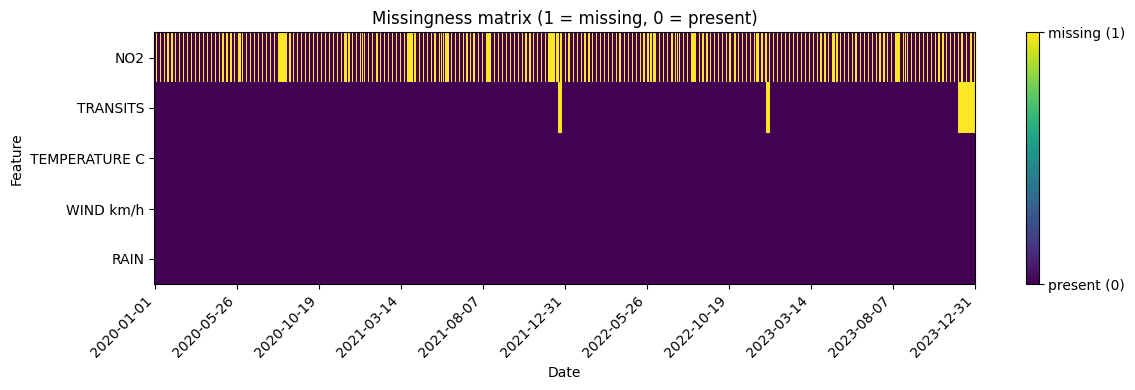

In [27]:
%run ../utilities/preprocess_all_with_holes.py

From the plots, NO2 measurements are highly fragmented over time—I rarely have more than a few consecutive days with data. So the only practical choice is to keep only the days where both NO2 and traffic are available. Let’s see how many observations that leaves us with and save the new cleaned dataset in data\preprocessed\preprocessed_all.py:

In [28]:
%run ../utilities/preprocess_all.py

Rows kept: 917 | Rows removed: 544


### Looking for outliers

Now that I’ve cleaned the gaps, the next step is an extra check for outliers:
count how many there are, see where they occur (target vs. features), and measure how much they skew the model’s performance. Based on that, I’ll decide whether to keep them, cap/transform them, or remove them.

I’m using the IQR (Tukey) rule for outliers. I chose this method because it’s simple, robust, and distribution-free (it doesn’t assume normality) and works well with skewed data.

NO2 (µg/m³): bounds [-1.50, 122.50] | outliers 9/688


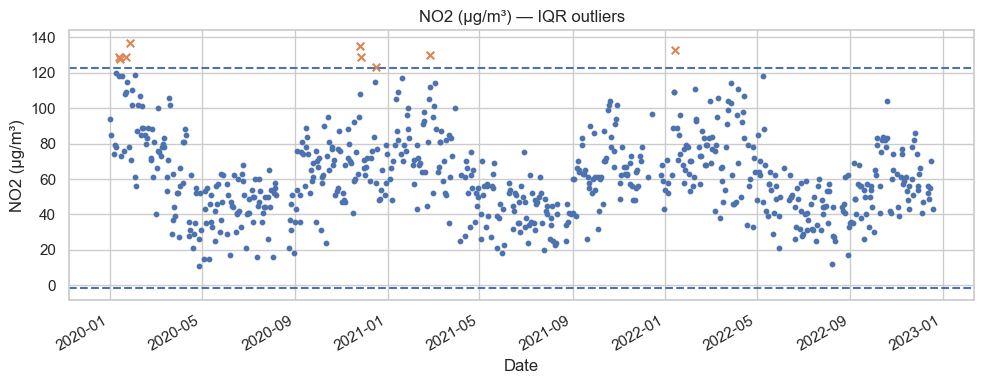

Transits (cars/day): bounds [68926.25, 192884.25] | outliers 54/688


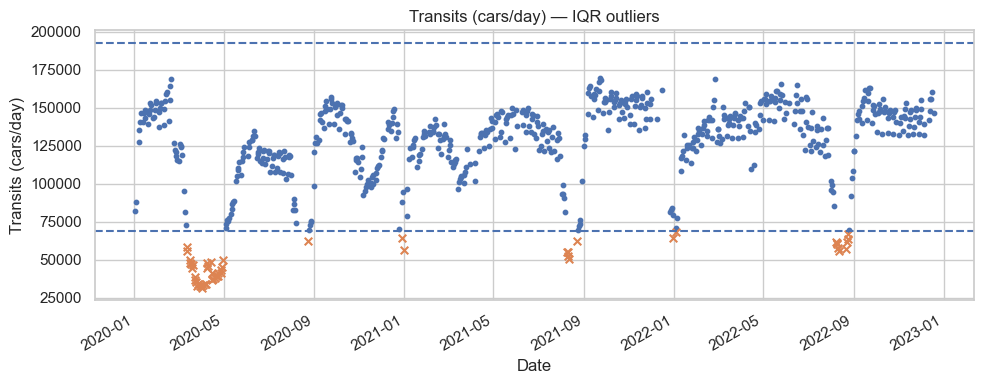

Temperature (°C): bounds [-13.00, 43.00] | outliers 0/688


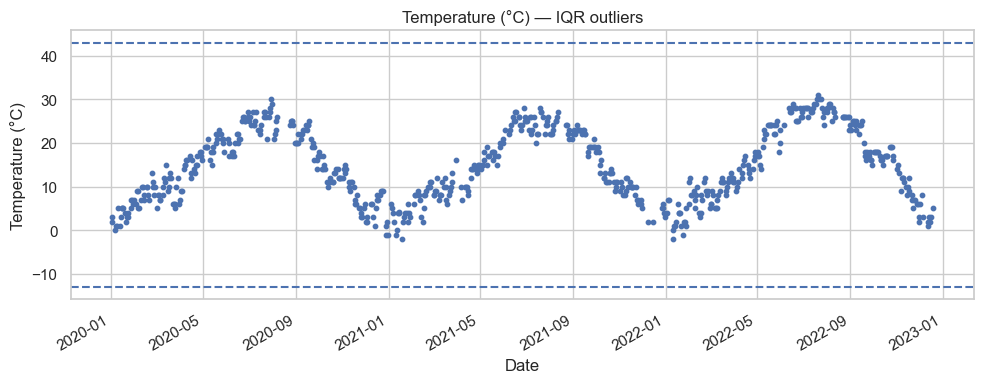

Wind (km/h): bounds [0.50, 12.50] | outliers 39/688


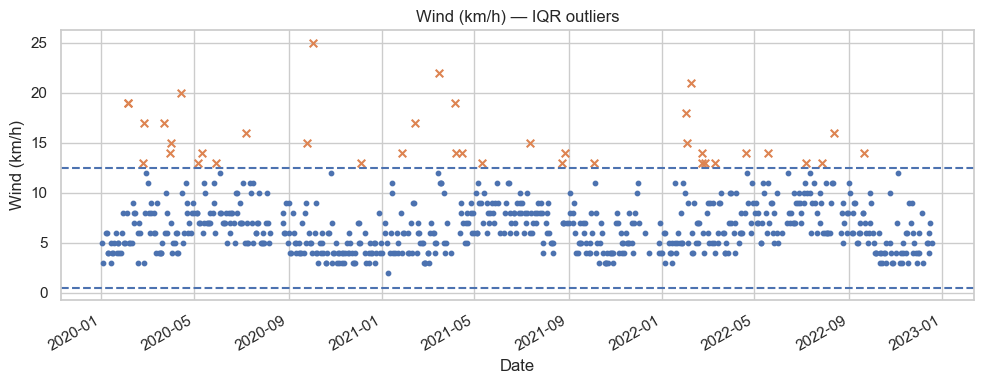

In [48]:

%run ../utilities/outliers.py

Here’s my read from the plots:

- NO₂: very few outliers (~1.3%). I’ll keep them—it’s plausible some days were genuinely worse (and note how often values sit above 40 µg/m³, the EU legal limit).

- Traffic: lots of outliers in 2020 (lockdown period) and around holidays/vacations when people leave the city—this matches reality, so I’ll keep them.

- Temperature: no meaningful outliers.
- Wind: the outliers are quite present (~5.6%), but it's also normal to have stormy days. Also I see that the variance is quite low, so I definitely need these outliers to have some information. 

- Conclusion: I’ll keep all the outliers.

I’m left with 917 observations almost random in time. That’s not ideal here, because NO₂ often reacts with a lag to its drivers (traffic, weather), so consecutive days would be more informative. Still, I’ll proceed with the matched days I have, keeping this limitation in mind. Finally, 917 observations for 4 features may not be sufficient, since each additional feature makes the sample less ‘dense’ (the curse of dimensionality). Therefore, I will likely drop one feature after a more detailed analysis to ensure greater stability of the model.

### Splitting Dataset

I split the clean dataset into two chronological parts:

- The oldest 75% goes to the training set (data/processed/train.csv).

- The most recent 25% goes to the test set (data/processed/test.csv).

In [11]:
%run ../utilities/split_preprocessed_all.py

688 rows in train.csv
229 rows in test.csv
Train range: 2020-01-02 → 2022-12-19
Test  range: 2022-12-20 → 2023-11-30


### EDA 

Now that I have training.csv, it’s time to explore the data to get a high-level picture. I’ll look at how each variable is distributed, how spread out the values are, and—most importantly—how strongly they correlate with the target (NO₂). 

##### 1) EDA NO2

NO2 EDA:
mean:   61.36
median: 59.00
std:    23.06
min:    11.00 on 2020-04-27
max:    137.00 on 2020-01-28
Q1/Q3:  45.00 / 76.00  (IQR=31.00)


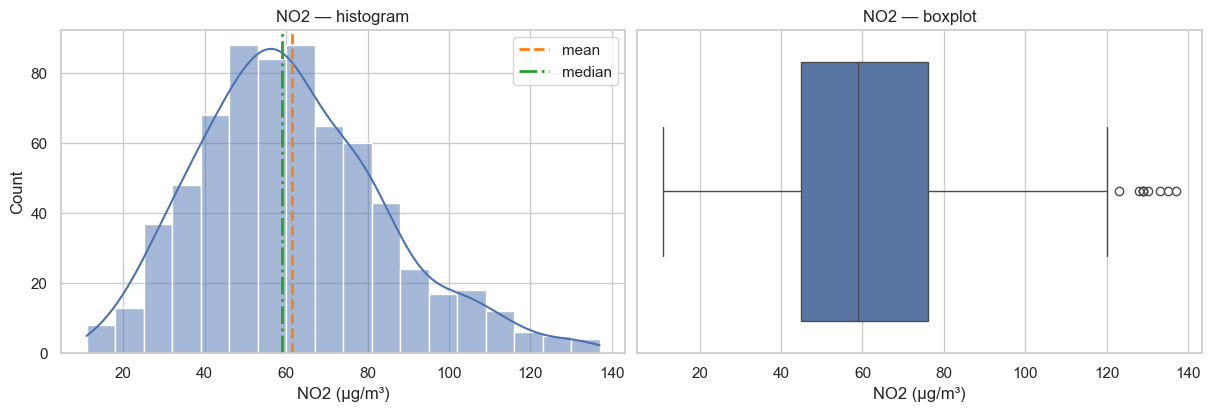

In [12]:
%run ../utilities/eda_air.py


- NO2 looks moderately high on average with mean 61.4 (remember that EU legal limits are 40 µg/m³!!!) and with a wide spread (IQR 31, std 23).
- Because the mean > median, the distribution is right-skewed: most days sit between ~45 and ~76. 
- The cluster of boxplot outliers around 120–140 suggests episodic high-pollution events that we already have seen in a dedicated plot.

#### 2) EDA traffic

TRANSITS EDA:
mean:   125008.80
median: 133052.00
std:    30593.11
min:    31319 on 2020-04-02
max:    169411 on 2021-09-23
Q1/Q3:  115410 / 146400  (IQR=30990)

Correlation with NO₂:
  Pearson:  0.255
  Spearman: 0.261


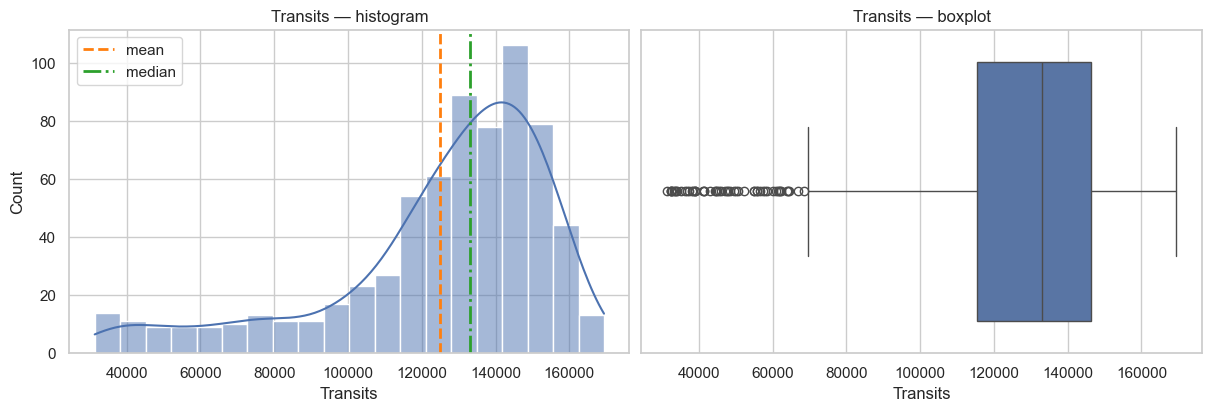

In [13]:
%run ../utilities/eda_traffic.py

- The mean being lower than the median confirms the left-skewness of the distribution. Also it reflects the pandemic period with very low traffic in early 2020 that pulls the average down.
- The spread is quite wide. This is because traffic varies a lot day to day.
- Link to NO2: modest positive correlation (Pearson 0.255, Spearman 0.261). It might seem surprising at the beginning, because cars actively produce NO2, but actually the daily NO2 is driven by more than traffic. There is also a very important contribution of other sources- like winter heating or nearby industry. Also, the chemistry is lagged, so today’s emissions don’t always show up as today’s NO2. Add a bit of missing/noisy data, and it’s no surprise the correlation is only modest rather than strong.

#### 3) EDA Temperature

EDA TEMPERATURE (°C): 
mean:   14.84°C
median: 14.00°C
std:    8.05°C
min:    -2.00°C on 2021-01-18
max:    31.00°C on 2022-07-21
Q1/Q3:  8.00°C / 22.00°C  (IQR=14.00°C)

Correlation NO₂ ~ Temperature:
  Pearson:  -0.529
  Spearman: -0.547


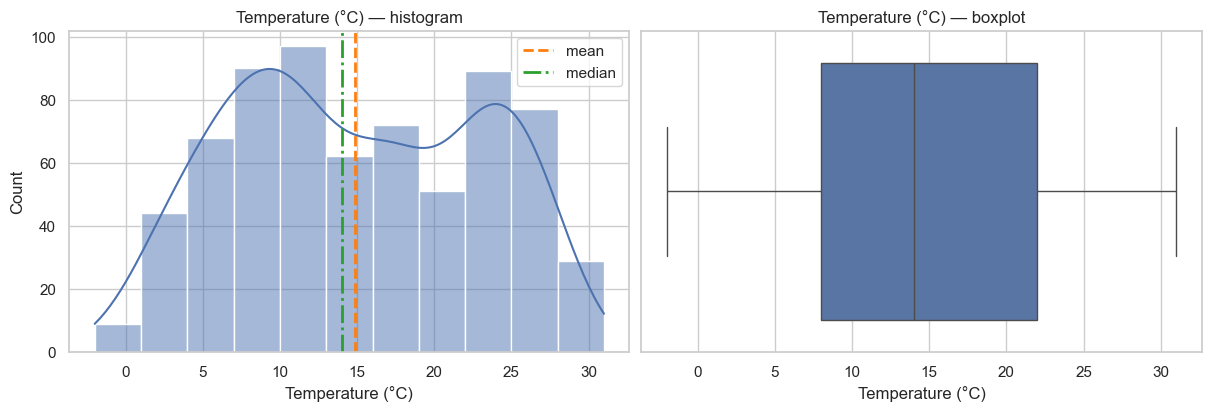

In [14]:
%run ../utilities/eda_temperature.py

- Temperature spans the full seasonal range. The mean (14.8 °C) is close to the median (14 °C), so the distribution is fairly balanced—just wider because of seasons.
- The temperature distribution isn’t bell-shaped; it’s bimodal, with two peaks: one around ~10 °C (cool seasons) and another around ~25 °C (warm seasons).
- NO2 shows a moderate-to-strong negative relationship with temperature (Pearson −0.529, Spearman −0.547). That's because on warm days the air disperses pollution better and we use less heating—so NO₂ tends to be lower. In cold months the air is more stagnant, pollution gets trapped near the ground, and heating adds extra NO₂. 
- The similar Pearson/Spearman values suggest this is a robust monotonic trend.

#### 4) EDA Wind 

 EDA WIND: 
mean:   6.93 km/h
median: 6.00 km/h
std:    3.08 km/h
min:    2.00 km/h on 2021-01-08
max:    25.00 km/h on 2020-10-02
Q1/Q3:  5.00 / 8.00 km/h  (IQR=3.00 km/h)

Correlation NO₂ ~ Wind:
  Pearson:  -0.282
  Spearman: -0.387


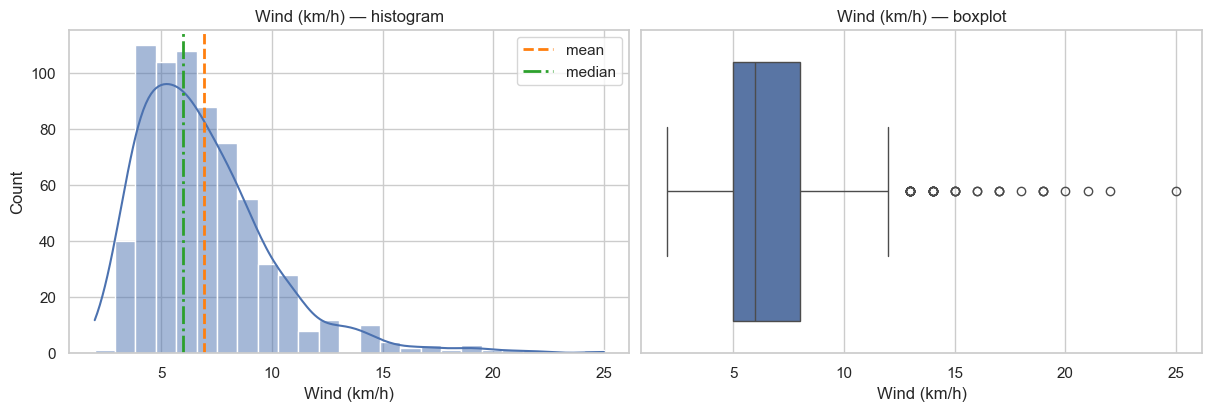

In [15]:
%run ../utilities/eda_wind.py


- Mean (6.9) > median (6) ⇒ a slight right-skew from the windy days.

- Spread: is moderate, so most days cluster around 5–8 km/h.

- Correlation to NO₂: negative and modest-to-moderate (Pearson −0.282, Spearman −0.387): more wind → better dispersion → lower NO₂.

- Shape of relationship: Spearman is stronger than Pearson, suggesting a monotonic but not perfectly linear effect.

#### 5) EDA Rain

In [16]:
%run ../utilities/eda_rain.py

EDA RAIN:
Days without rain: 473
Days with rain:    215
Share of rainy days: 0.312

Mean NO₂ by rain:
  No rain: 63.08
  Rain: 57.58

Correlation NO₂ ~ RAIN (RAIN=0/1):
  Pearson (point-biserial): -0.111
  Spearman:                 -0.118


- Rainy days are about 34% of the sample.
- The relationship is weak (Pearson −0.23, Spearman −0.22): rain helps wash out pollutants, but it’s definitely not the only driver of NO₂ levels.

#### 6) Correlation Heatmap 

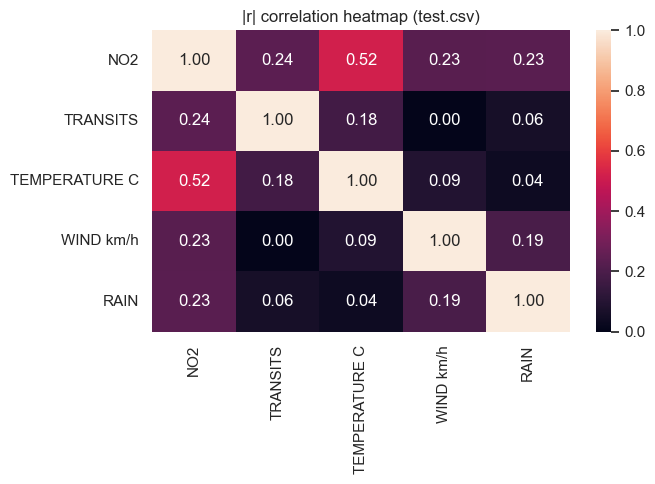

In [17]:
%run ../utilities/corr_heatmap.py

- The most surprising result to me is that the correlation between temperature and rain is just 0.04. I think this happens because using rain as a boolean value instead of actual rainfall amounts (in mm) is too imprecise. Keeping in mind also what I have said about dimensionality, I have decided not to use rain feature anymore. 
- The correlation among the other independent variables is almost negligible, so I can exclude multicollinearity. 
- As for their relationship with the target variable, it ranges from weak (wind, traffic) to moderate in the case of temperature, but never to the point of suggesting leakage. Therefore, I decided to keep all three.

### Exploring Regression Models

##### 1) With Default Hyperparameters & NO2 Outliers

I started by testing five regression models with their default hyperparameters, just to get a first baseline.

- **Linear Regression** – the simplest model, no hyperparameters.

- **Lasso Regression**  - default: alpha=1.0, max_iter=1000 (I don't think that there's any risk of overfitting with my dataset, because it's small, so I will just use it out of curiosity).

- **Polynomial Regression (degree = 2)** – to check if simple non-linear patterns exist, no hyperparameters.

- **Random Forest** – default: n_estimators=100, max_depth=None, max_features=1.0.

- **XGBoost** – default: n_estimators=100, learning_rate=0.1, max_depth=6, subsample=1.0, colsample_bytree=1.0, reg_alpha=0, reg_lambda=1.

This gives me a quick baseline to compare before trying any tuning or optimization.


=== CV Results (Default Hyperparameters) ===
        Model   CV_RMSE    CV_MAE    CV_R2
       Linear 18.536563 14.599192 0.347579
        Lasso 18.590750 14.554175 0.344399
Polynomial(2) 18.205189 14.335147 0.370755
 RandomForest 19.300199 15.175663 0.287998
      XGBoost 21.937969 17.003350 0.082014


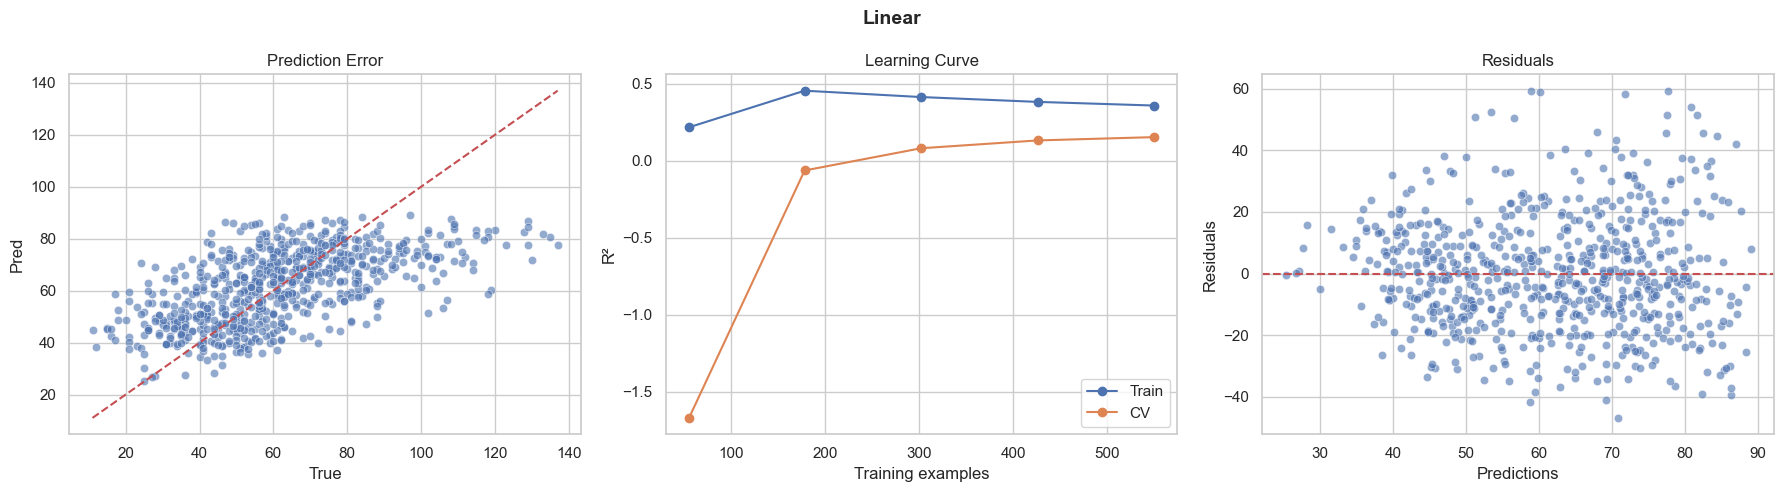

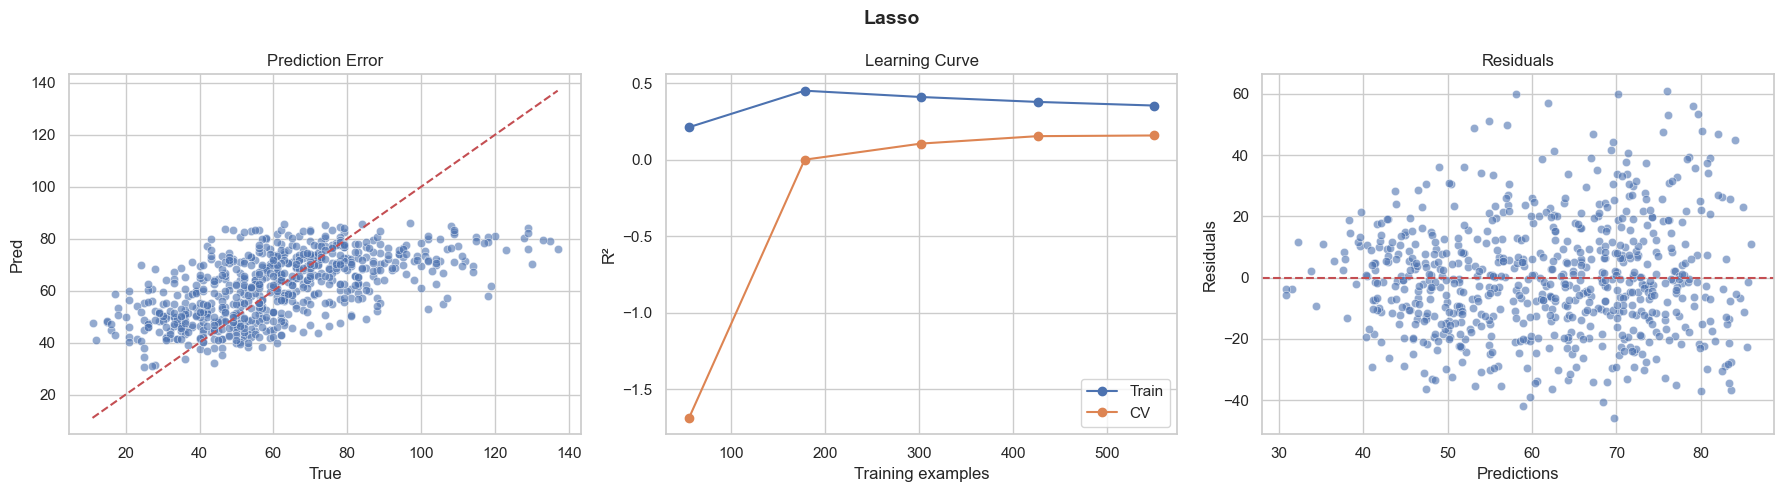

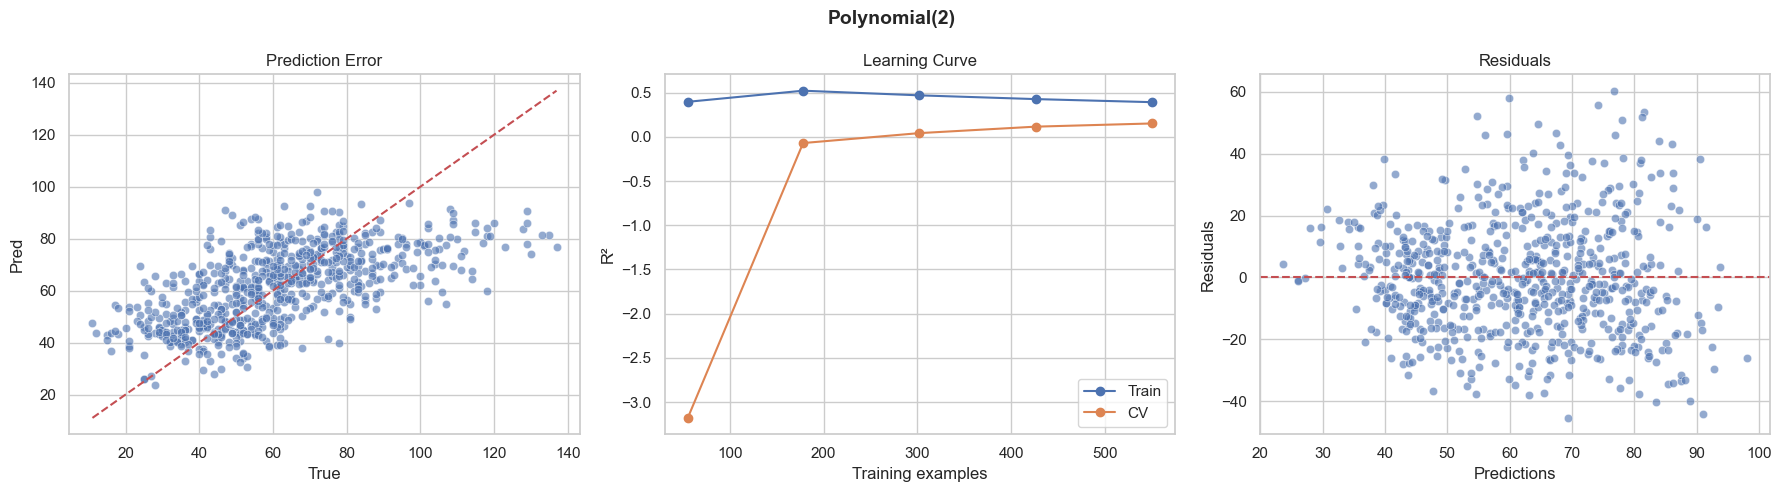

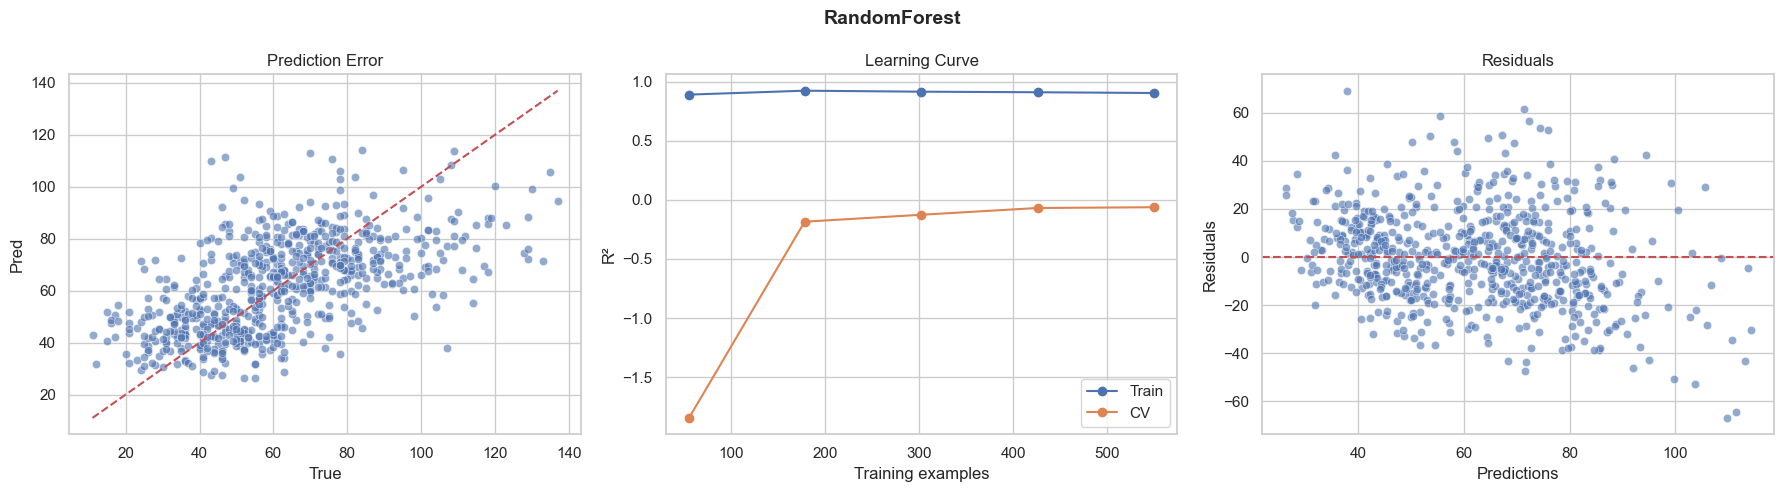

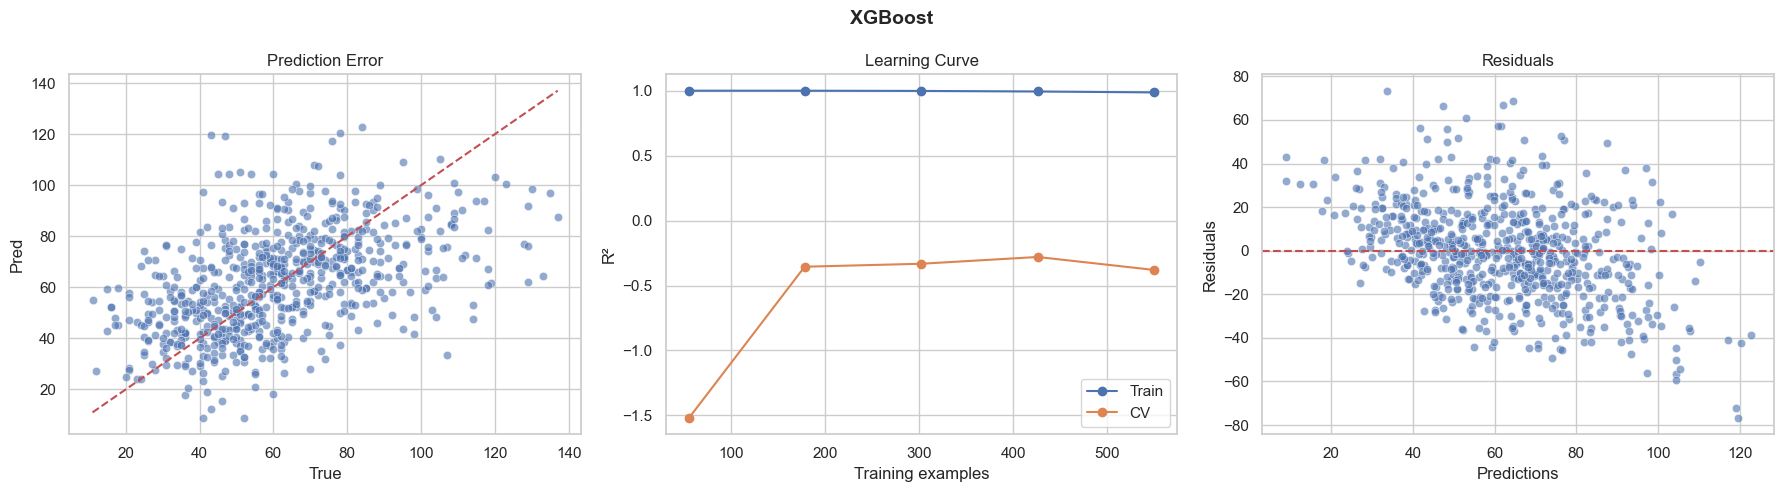

In [ ]:
%run ../utilities/model_training_hp_default.py --train-file ../data/processed/train.csv --target NO2 --features "TRANSITS,TEMPERATURE C,WIND km/h"

- **Polynomial (2)** came out slightly better: lowest RMSE and highest R². Adding quadratic terms helped capture a bit of non-linearity.

- **Linear and Lasso** look almost the same. Lasso doesn’t bring much benefit here.

- **Random Forest** actually performed worse (higher RMSE, R² ~0.29). With default settings, it doesn’t model the data well.

- **XGBoost** is the weakest, showing that it really needs proper tuning on this dataset.

- **Prediction error**: All models tend to underestimate the high NO2 values. This is probably because none of the current features has a strong influence on the peaks, so the models can’t capture them properly. 

- **Learning curves**: linear models improve a bit with more data but quickly hit a ceiling. Random Forest and XGBoost show a big gap between train and CV, which is a clear sign of overfitting.

- **Residuals**: mostly random, but bigger errors show up at the extremes: models struggle with very high or very low cases (outliers).

##### 2) With Default Hyperparameters & NO2 Outliers Transformed 

We already saw that NO₂ has very few outliers (9 out of 688) and decided to keep them. But since all five models struggle with outliers, we’ll try capping during training: any value below the lower bound is set to the bound, and any value above the upper bound is also set to the bound.




In [48]:
%run ../utilities/train_log_outliers_NO2.py

Saved new dataset with capped NO2 outliers in train_log_outliers_NO2.csv



=== CV Results (Default Hyperparameters) ===
        Model   CV_RMSE    CV_MAE    CV_R2
       Linear 18.266512 14.481075 0.349668
        Lasso 18.320008 14.443554 0.346556
Polynomial(2) 17.927738 14.219275 0.373680
 RandomForest 18.881935 14.913117 0.301424
      XGBoost 21.497575 16.863461 0.094431


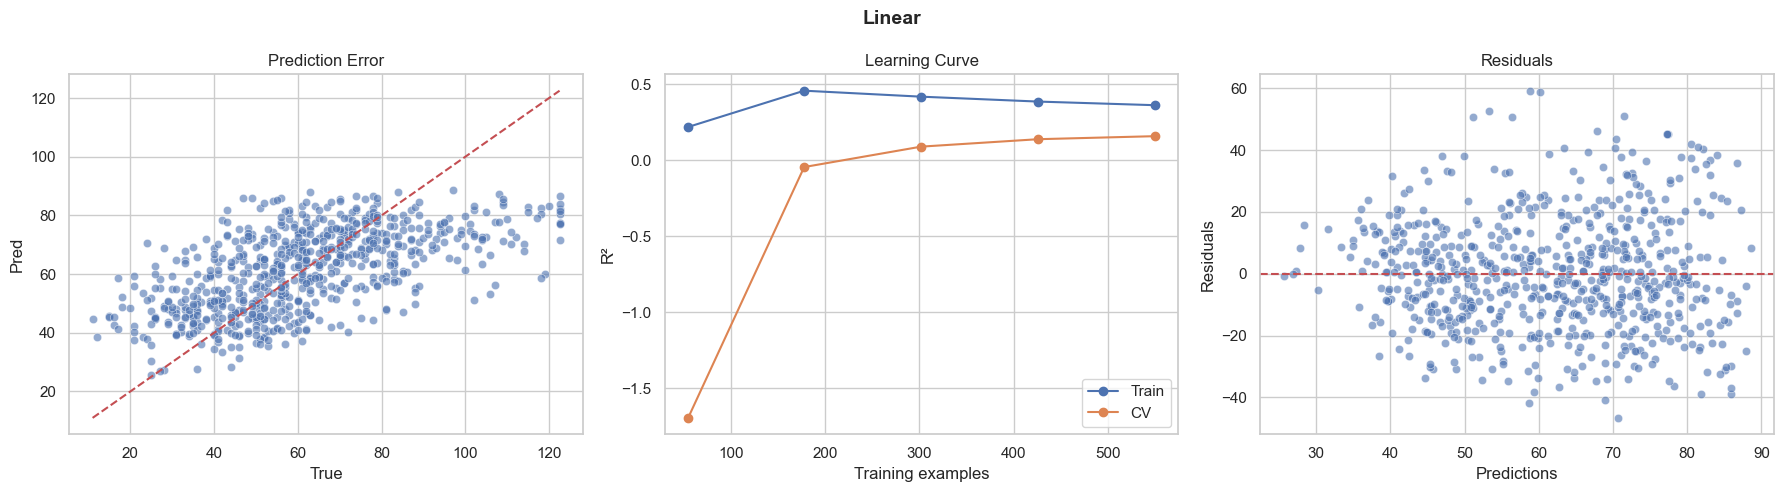

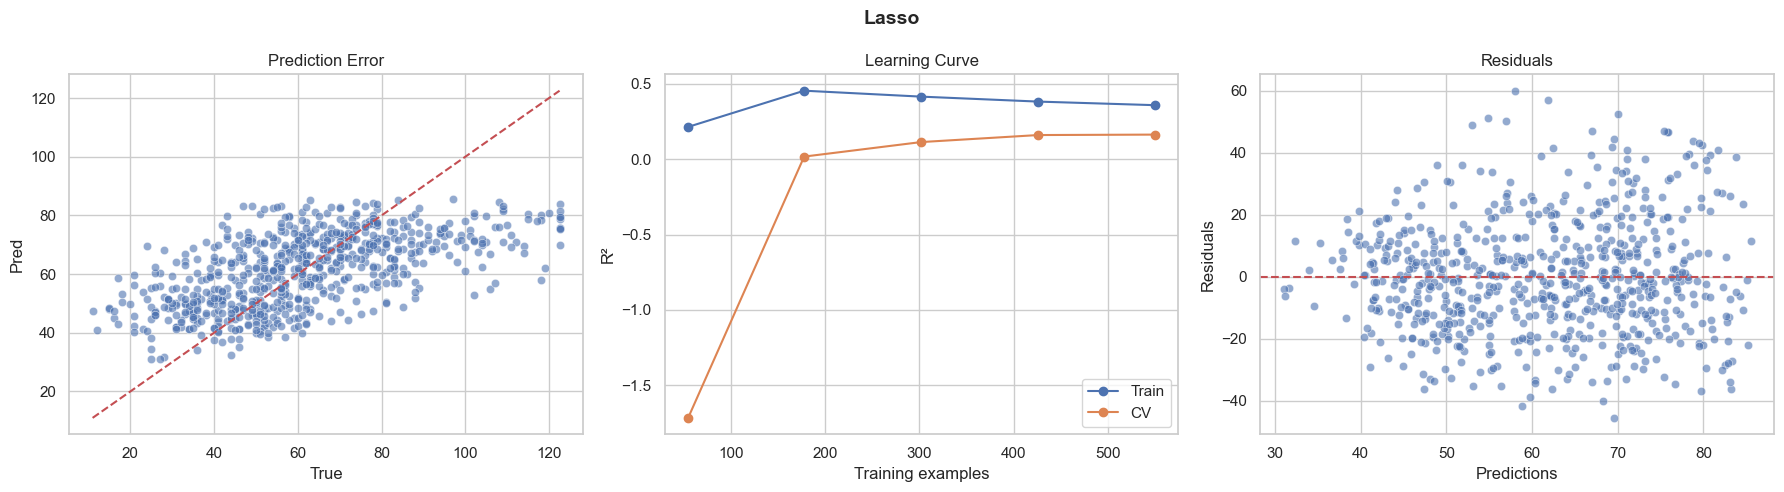

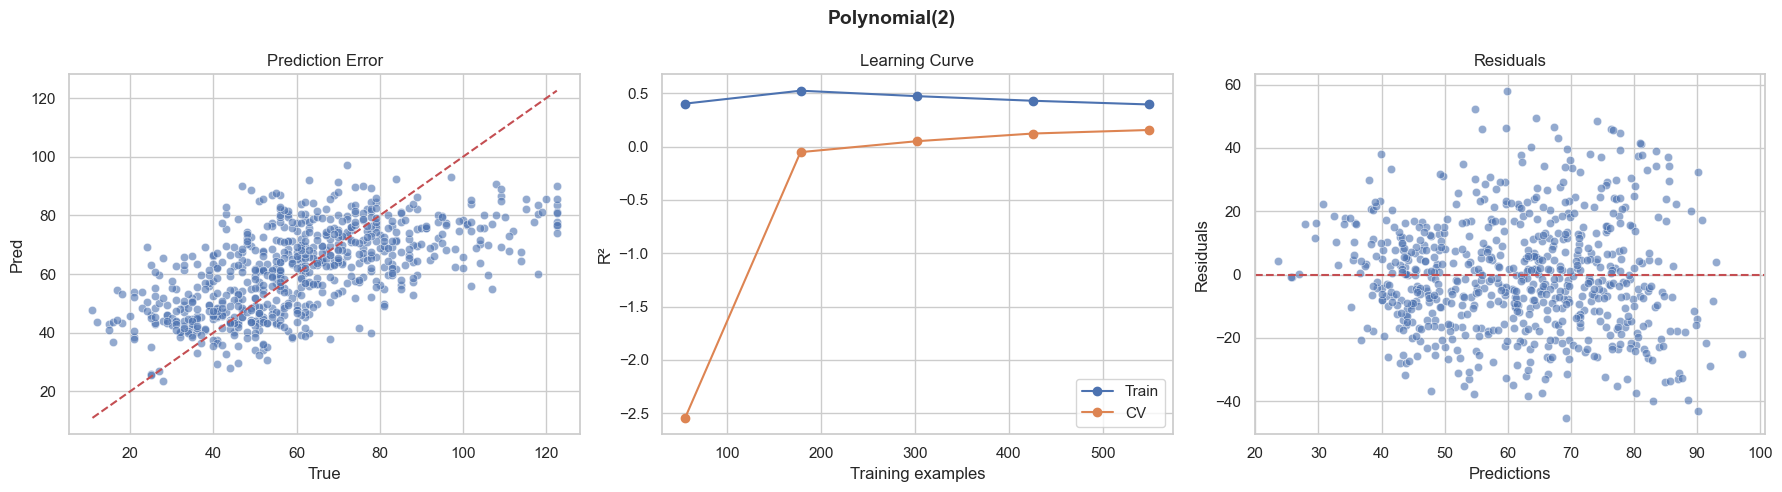

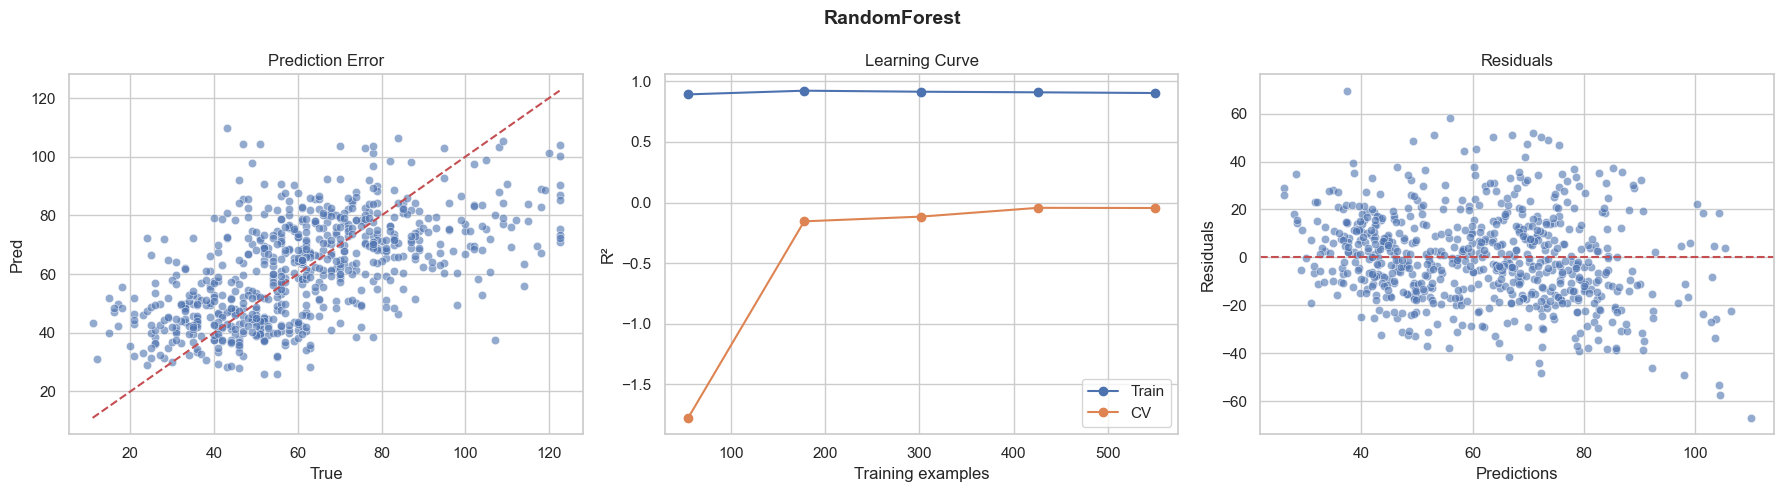

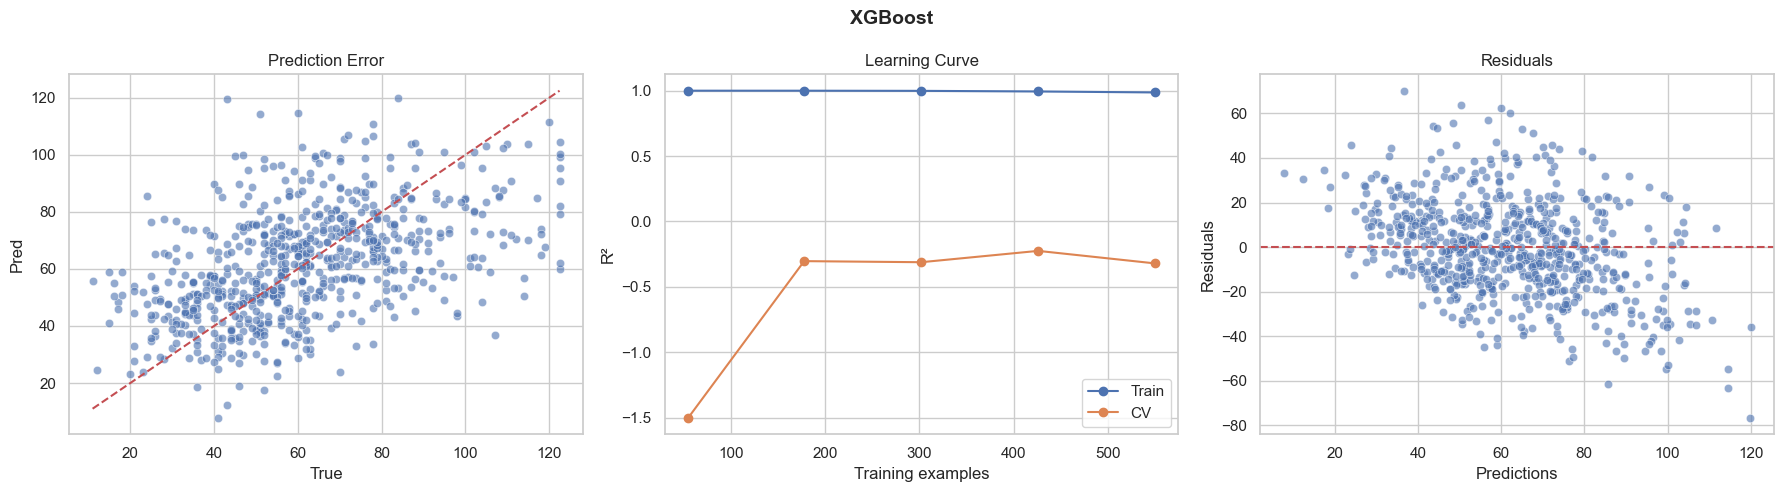

In [49]:
%run ../utilities/model_training_hp_default.py --train-file ../data/processed/train_log_outliers_NO2.csv --target NO2 --features "TRANSITS,TEMPERATURE C,WIND km/h"

All models improved a little (lower RMSE and MAE, higher R²) and became more stable, but the ranking didn’t change: Polynomial(2) > Linear/Lasso > Random Forest > XGBoost. 

##### 3) With Tuned Hyperparameters & NO2 Outliers Transformed


=== CV Results (Tuned) ===
       Model   CV_RMSE    CV_MAE    CV_R2
RandomForest 17.679580 13.956218 0.390681
     XGBoost 19.193922 15.002073 0.281662

=== Random Forest Parameters ===
                  Tuned Default
param                          
n_estimators        800     100
max_depth             8    None
min_samples_split     5       2
min_samples_leaf      4       1
max_features        0.5     1.0
bootstrap          True    True

=== XGBoost Parameters ===
                Tuned  Default
n_estimators   600.00    100.0
max_depth        4.00      6.0
learning_rate    0.03      0.1

Saved best params to: ../results/best_params.json


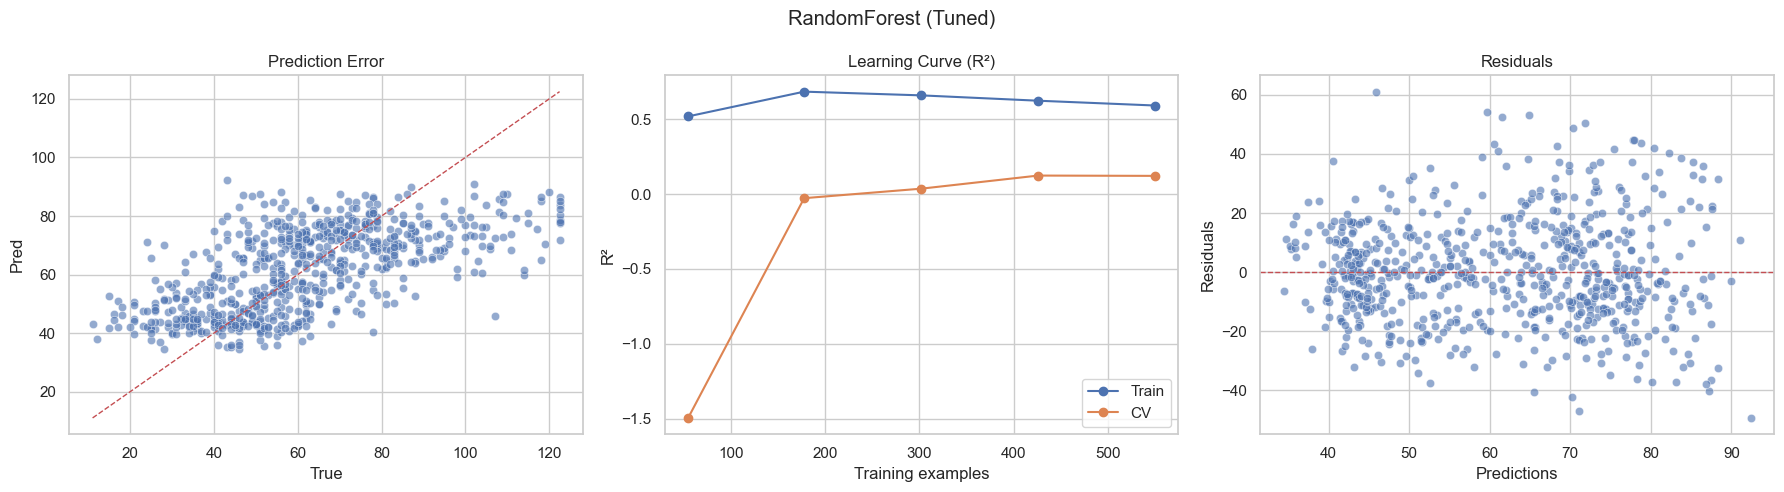

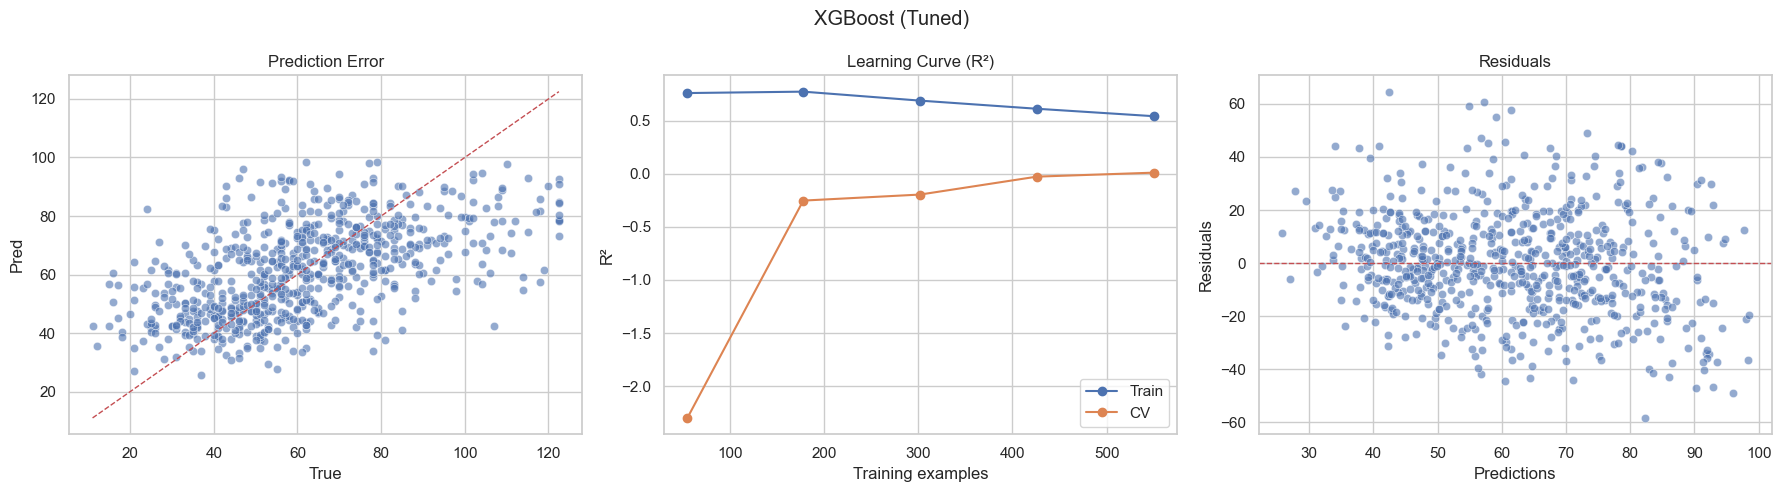

In [71]:
%run ../utilities/tuning_rf_xgb.py \
  --train-file ../data/processed/train_log_outliers_NO2.csv \
  --target NO2 \
  --features "TRANSITS,TEMPERATURE C,WIND km/h" \
  --save-params ../results/best_params.json



- **Random Forest**: after tuning it improved a lot — it explains more of the variability and makes smaller errors on average. The learning curves still show a gap between training and CV, so there’s still some overfitting.

- **XGBoost**: tuning also helped, but even with the progress it’s still worse than Random Forest. The learning curves show it struggles more to generalize.

##### 4) Comparing Models and Results

| Model               | CV_RMSE        | CV_MAE        | CV_R2        |
|----------------------|----------------|---------------|--------------|
| RandomForest         | 19.30 → 18.88 → **17.68** | 15.18 → 14.91 → **13.96** | 0.288 → 0.301 → **0.391** |
| Polynomial (2)       | 18.21 → **17.93** | 14.34 → **14.22** | 0.371 → **0.374** |
| Linear               | 18.54 → **18.27** | 14.60 → **14.48** | 0.348 → **0.350** |
| Lasso                | 18.59 → **18.32** | 14.55 → **14.44** | 0.344 → **0.347** |
| XGBoost              | 21.94 → 21.50 → **19.19** | 17.00 → 16.86 → **15.00** | 0.082 → 0.094 → **0.282** |


- **Random Forest (tuned)** has the lowest RMSE and highest R² → it captures more variability and makes fewer errors. However the method is quite heavy and slow. 

- **Polynomial (2)** is very close and performs quite well given its simplicity. Slower then linear methods, but still fast.

- **Linear / Lasso** have good baselines, but are less accurate. Very light and fast. 

- **XGBoost** does the worst performance, maybe because the dataset is not big enough or maybe because the relationship between NO2 and other variables is quite simple. 

Conclusion: I choose Random Forest (tuned) because it predicts better than the other methods. Even though it’s heavier than the others, the higher accuracy makes it worth the cost.

### Feature Importance and Correlations

We already looked at the simple statistical correlation between each feature and NO2. Now we go one step further and check what the optimized Random Forest model tells us. Even though Random Forest is still just an approximation of the data, it gives us extra insights:

- it shows how much each feature matters when all variables are considered together (not just one by one)

- it captures non-linear effects and interactions between features

- it tells us how much the model’s predictions actually depend on each feature (through permutation importance).

This way we can confirm the correlations we saw earlier, but also understand better the relative weight of temperature, traffic, and wind in predicting NO2.


=== Random Forest — Built-in Feature Importances ===
      Feature  Importance
TEMPERATURE C    0.485000
     TRANSITS    0.277366
    WIND km/h    0.237633


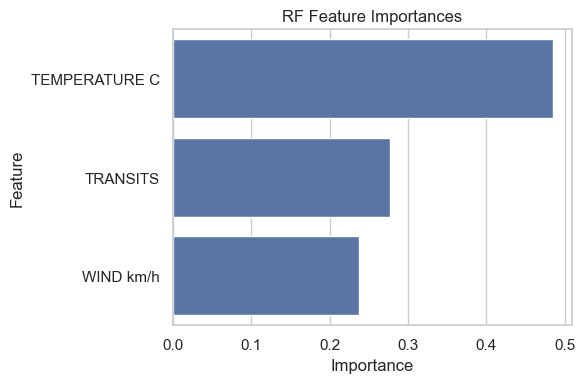


=== Random Forest — Permutation Importance (ΔR²) ===
      Feature  PermImportance      Std
TEMPERATURE C        0.533796 0.022620
     TRANSITS        0.245369 0.018970
    WIND km/h        0.226610 0.014993


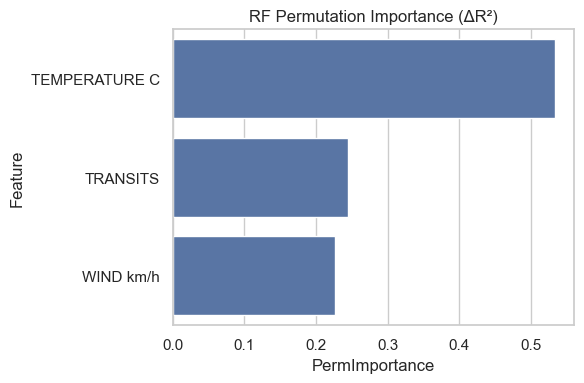

In [73]:
%run ../utilities/forest_parameters.py

Let’s put all the results together in one summary table:

| Feature       | Pearson Corr. | Spearman Corr. | Built-in Importance | Permutation Importance |
|---------------|---------------|----------------|---------------------|-------------------------|
| TEMPERATURE C | -0.529        | -0.547         | 0.485               | 0.534                   |
| TRANSITS      |  0.255        |  0.261         | 0.277               | 0.245                   |
| WIND km/h     | -0.282        | -0.387         | 0.238               | 0.227                   |


Both the correlation analysis and the Random Forest feature importances point to the same story:

- **Temperature** is the most important driver of NO2 levels: strong negative correlation, highest feature importance in the model.

- **Traffic** has a positive moderate correlation and medium importance in the model.

- **Wind** has a moderate negative correlation with similar importance to traffic.

In short: temperature dominates, while traffic and wind both contribute but with smaller, similar weights. The Random Forest model confirms what we already saw in the correlations,

### Final Conclusions

This project tested different regression models to predict NO2 in Milan, using a dataset that was far from perfect. Still, even with limited data, machine learning gave us some useful insights.

On one hand, we cannot control temperature in the short term. But the strong correlation with temperature likely reflects something we can act on: when it’s cold, heating systems are switched on, adding a big source of emissions. Alongside this, traffic is another factor we can directly reduce.

The solution is clear: cleaner heating and less traffic could make a real difference in reducing air pollution in Milan, which remains one of the most polluted cities in Europe.